<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/Matrix_approach/ABA_recommender_MF_28_4_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [36]:
!pip install surprise

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from scipy import linalg
from datetime import datetime
from surprise import Reader, Dataset, SVD, SVDpp, NMF, KNNBaseline,CoClustering,KNNBasic, KNNWithMeans,KNNWithZScore,SlopeOne,accuracy

from surprise.model_selection import cross_validate
from surprise.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 



In [38]:
#path = '/content/drive/MyDrive/AdvancedBA/Olie_data/'
path ='/content/drive/MyDrive/olist_project/'
data = pd.read_csv(path+'recommender.csv')

In [39]:
data.head()

,Unnamed: 0,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_delivered_customer_date,price,delivered_date,days_diff,order_weekday,order_month,price_category,day_category
0,0,4,SP,SP,17106,housewares,45758,2017-10-10 21:25:13,29.99,2017-10-10,8.0,Monday,Oct,Low,morning
1,1,4,SP,SP,17106,housewares,21530,2017-08-18 14:44:43,29.99,2017-08-18,3.0,Tuesday,Aug,Low,afternoon
2,2,5,SP,SP,17106,housewares,87936,2017-08-07 18:30:01,29.99,2017-08-07,5.0,Wednesday,Aug,Low,afternoon
3,3,3,SC,SP,17106,housewares,85228,2017-11-07 18:04:59,29.99,2017-11-07,15.0,Monday,Oct,Low,evening
4,4,1,SP,SP,23951,housewares,44958,2017-08-28 20:12:20,46.80,2017-08-28,4.0,Thursday,Aug,Low,morning


In [40]:
data = data.iloc[:,1:]

In [41]:
data.shape

(111686, 14)

In [42]:
data = data.drop_duplicates()

In [43]:
data.shape

(101173, 14)

In [44]:
raitings_df = data[['customer_unique_id','product_id','review_score']]

In [45]:
raitings_df.head()

,customer_unique_id,product_id,review_score
0,45758,17106,4
1,21530,17106,4
2,87936,17106,5
3,85228,17106,3
4,44958,23951,1


# Deepthi implementation-clean version


In [46]:
train_df, test_df = train_test_split(raitings_df, train_size=0.7, random_state = 0) # 2/3 -training 

In [47]:
# function to calculate the RMSE
def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred) / np.sqrt(len(y_true))

In [48]:
def performance(user,product,model):
  y_pred = []
  for user_id, product_id in zip(user, product):
    r = model.predict(user_id, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    y_pred.append(r)
  y_pred = np.array(y_pred)
  return y_pred

In [49]:
# function to make the boxplot
def MakeBoxplot(y_true, y_pred, title):
    data = [y_pred[y_true == (x*0.5+0.5)] for x in range(10)]
    fig = plt.figure(figsize=(5, 5))
    plt.boxplot(data)
    min_a, max_a = 0., 5.0
    plt.xlim((min_a, max_a))
    plt.ylim((min_a, max_a))
    plt.plot([min_a, max_a * 2], [min_a, max_a], ls='--', color='gray', linewidth=1.0)# x & y values of 2 points of the plot
    plt.xticks(range(12), [x*0.5 for x in range(12)])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()

In [18]:
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(train_df, reader)

In [50]:
# chosen models
models = ['svd','svd++','nmfb','nmf','CoClustering']

# values needed for predictions
y_true = test_df['review_score'].values 
user_ids_true = test_df['customer_unique_id'].values
product_ids_true = test_df['product_id'].values



for i in models:
  if i == 'svd':
    param_grid = {'n_factors': [70, 80, 90, 100, 110, 120, 130, 140, 150, 160], 
                  'n_epochs': [100], 
                  'reg_all': [0.1]}
    gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3) # cross validation 3-folds
    gs_svd.fit(data_surprise)
    best_svd = gs_svd.best_score['rmse']
    best_svd_params = gs_svd.best_params['rmse']
    model_svd = gs_svd.best_estimator['rmse']
    model_svd.fit(data_surprise.build_full_trainset())
    y_pred_svd = performance(user_ids_true,product_ids_true,model_svd)
    error_svd = RMSE(y_true, y_pred_svd)
  
  elif i == 'svd++':
    param_grid = {'lr_all': [0.001, 0.003, 0.005, 0.007, 0.009], 
                  'reg_all': [0.005, 0.01, 0.015, 0.02, 0.025]}
    gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3)
    gs_svdpp.fit(data_surprise)
    best_svd_plus = gs_svdpp.best_score['rmse']
    best_svd_plus_params = gs_svdpp.best_params['rmse']
    model_svd_plus = gs_svdpp.best_estimator['rmse']
    model_svd_plus.fit(data_surprise.build_full_trainset())
    y_pred_svd_plus = performance(user_ids_true,product_ids_true,model_svd_plus)
    error_svd_plus = RMSE(y_true, y_pred_svd_plus)


  elif i == 'nmfb':
    param_grid = {'n_factors': [1,2,3,4,5,6,7,8,9,10], 
                  'n_epochs': [100], 
                  'biased': [True], 
                  'reg_bu': [0.1], 
                  'reg_bi': [0.1]}
    gs_nmfb = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3)
    gs_nmfb.fit(data_surprise)
    best_nmfb = gs_nmfb.best_score['rmse']
    best_nmfb_params = gs_nmfb.best_params['rmse']
    model_nmfb = gs_nmfb.best_estimator['rmse']
    model_nmfb.fit(data_surprise.build_full_trainset())
    y_pred_nmfb = performance(user_ids_true,product_ids_true,model_nmfb)
    error_nmfb = RMSE(y_true, y_pred_nmfb)

  elif i == 'nmf':
    param_grid = {'n_factors': [200, 220, 240], 
                  'n_epochs': [100]}
    gs_nmf = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3)
    gs_nmf.fit(data_surprise)
    best_nmf = gs_nmf.best_score['rmse']
    best_nmf_params = gs_nmf.best_params['rmse']
    model_nmf = gs_nmf.best_estimator['rmse']
    model_nmf.fit(data_surprise.build_full_trainset())
    y_pred_nmf = performance(user_ids_true,product_ids_true,model_nmf)
    error_nmf = RMSE(y_true, y_pred_nmf)

  elif i == 'CoClustering':
    param_grid = {'n_cltr_u': [3,4,5], 
                  'n_cltr_i': [3,4,5],'n_epochs':[20,100]}
    gs_CoClustering = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=3)
    gs_CoClustering.fit(data_surprise)
    best_CoClustering = gs_CoClustering.best_score['rmse']
    best_CoClustering_params = gs_CoClustering.best_params['rmse']
    model_CoClustering = gs_CoClustering.best_estimator['rmse']
    model_CoClustering.fit(data_surprise.build_full_trainset())
    y_pred_CoClustering = performance(user_ids_true,product_ids_true,model_CoClustering)
    error_CoClustering = RMSE(y_true, y_pred_CoClustering)

  
  







In [ ]:
# I want to run these models as well, but when I try to Run it crashes.
models = ['KNNBasic','KNNWithMeans','KNNWithZScore','KNNBaseline']

# values needed for predictions
y_true = test_df['review_score'].values 
user_ids_true = test_df['customer_unique_id'].values
product_ids_true = test_df['product_id'].values

for i in models:
  if i == 'KNNBasic':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNBasic = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
    gs_KNNBasic.fit(data_surprise)
    best_KNNBasic = gs_KNNBasic.best_score['rmse']
    best_KNNBasic_params = gs_KNNBasic.best_params['rmse']
    model_KNNBasic = gs_KNNBasic.best_estimator['rmse']
    model_KNNBasic.fit(data_surprise.build_full_trainset())
    y_pred_KNNBasic = performance(user_ids_true,product_ids_true,model_KNNBasic)
    error_KNNBasic = RMSE(y_true, y_pred_KNNBasic)

  elif i == 'KNNWithMeans':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
    gs_KNNWithMeans.fit(data_surprise)
    best_KNNWithMeans = gs_KNNWithMeans.best_score['rmse']
    best_KNNWithMeans_params = gs_KNNWithMeans.best_params['rmse']
    model_KNNWithMeans = gs_KNNWithMeans.best_estimator['rmse']
    model_KNNWithMeans.fit(data_surprise.build_full_trainset())
    y_pred_KNNWithMeans = performance(user_ids_true,product_ids_true,model_KNNWithMeans)
    error_KNNWithMeans = RMSE(y_true, y_pred_KNNWithMeans)

  elif i == 'KNNWithZScore':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNWithZScore = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=3)
    gs_KNNWithZScore.fit(data_surprise)
    best_KNNWithZScore = gs_KNNWithZScore.best_score['rmse']
    best_KNNWithZScore_params = gs_KNNWithZScore.best_params['rmse']
    model_KNNWithZScore = gs_KNNWithZScore.best_estimator['rmse']
    model_KNNWithZScore.fit(data_surprise.build_full_trainset())
    y_pred_KNNWithZScore = performance(user_ids_true,product_ids_true,model_KNNWithZScore)
    error_KNNWithZScore = RMSE(y_true, y_pred_KNNWithZScore)

  elif i == 'KNNBaseline':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]},
              'bsl_options': {'method': ['als', 'sgd']}}
    gs_KNNBaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3)
    gs_KNNBaseline.fit(data_surprise)
    best_KNNBaseline = gs_KNNBaseline.best_score['rmse']
    best_KNNBaseline_params = gs_KNNBaseline.best_params['rmse']
    model_KNNBaseline = gs_KNNBaseline.best_estimator['rmse']
    model_KNNBaseline.fit(data_surprise.build_full_trainset())
    y_pred_KNNBaseline = performance(user_ids_true,product_ids_true,model_KNNBaseline)
    error_KNNBaseline = RMSE(y_true, y_pred_KNNBaseline)




In [51]:
print(f'The best SVD score: {best_svd}\nThe best SVD parameters are: {best_svd_params}')
print(80*'-')
print(f'The best SVD++ score: {best_svd_plus}\nThe best SVD++ parameters are: {best_svd_plus_params}')
print(80*'-')
print(f'The best Biased NMF score: {best_nmfb}\nThe best Biased NMF parameters are: {best_nmfb_params}')
print(80*'-')
print(f'The best NMF score: {best_nmf}\nThe best NMF parameters are: {best_nmf_params}')
print(80*'-')
print(f'The best CoClustering score: {best_CoClustering}\nThe best CoClustering parameters are: {best_CoClustering_params}')
print(80*'-')
# print(f'The best KNNBasic score: {best_KNNBasic}\nThe best KNNBasic parameters are: {best_KNNBasic_params}')
# print(80*'-')
# print(f'The best KNNWithMeans score: {best_KNNWithMeans}\nThe best KNNWithMeans parameters are: {best_KNNWithMeans_params}')
# print(80*'-')
# print(f'The best KNNWithZScore score: {best_KNNWithZScore}\nThe best KNNWithZScore parameters are: {best_KNNWithZScore_params}')
# print(80*'-')
# print(f'The best KNNBaseline score: {best_KNNBaseline}\nThe best KNNBaseline parameters are: {best_KNNBaseline_params}')
# print(80*'-')



The best SVD score: 1.3460828316697053
The best SVD parameters are: {'n_factors': 110, 'n_epochs': 100, 'reg_all': 0.1}
--------------------------------------------------------------------------------
The best SVD++ score: 1.3456767430080248
The best SVD++ parameters are: {'lr_all': 0.009, 'reg_all': 0.025}
--------------------------------------------------------------------------------
The best Biased NMF score: 1.4529925728587372
The best Biased NMF parameters are: {'n_factors': 1, 'n_epochs': 100, 'biased': True, 'reg_bu': 0.1, 'reg_bi': 0.1}
--------------------------------------------------------------------------------
The best NMF score: 1.348772350210037
The best NMF parameters are: {'n_factors': 240, 'n_epochs': 100}
--------------------------------------------------------------------------------
The best CoClustering score: 1.3476994120715629
The best CoClustering parameters are: {'n_cltr_u': 4, 'n_cltr_i': 3, 'n_epochs': 20}
--------------------------------------------------

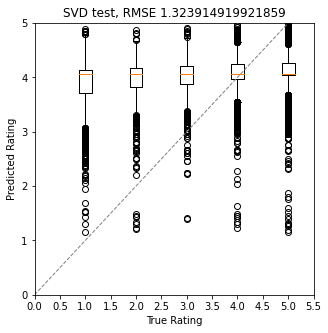

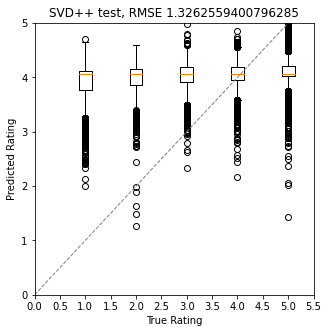

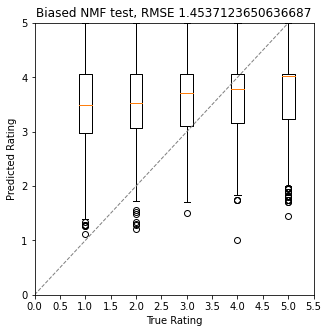

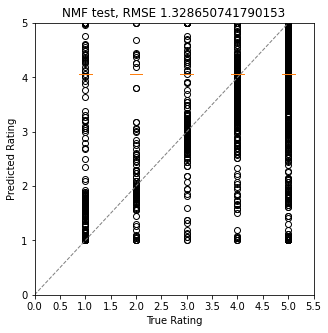

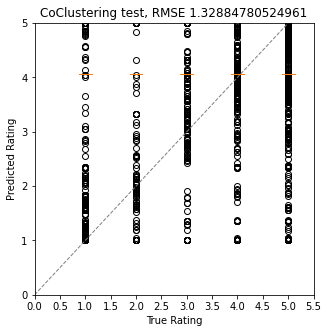

In [52]:


#svd
MakeBoxplot(y_true, y_pred_svd, 'SVD test, RMSE {}'.format(error_svd))

#svd++
MakeBoxplot(y_true, y_pred_svd_plus, 'SVD++ test, RMSE {}'.format(error_svd_plus))

#nmfb
MakeBoxplot(y_true, y_pred_nmfb, 'Biased NMF test, RMSE {}'.format(error_nmfb))

#nmf
MakeBoxplot(y_true, y_pred_nmf, 'NMF test, RMSE {}'.format(error_nmf))

#CoClustering
MakeBoxplot(y_true, y_pred_CoClustering, 'CoClustering test, RMSE {}'.format(error_CoClustering))

# #KNNBaseline
# MakeBoxplot(y_true, y_pred_KNNBaseline, 'KNNBaseline test, RMSE {}'.format(error_KNNBaseline))

# #KNNBasic
# MakeBoxplot(y_true, y_pred_KNNBasic, 'KNNBasic test, RMSE {}'.format(error_KNNBasic))

# #KNNWithMeans
# MakeBoxplot(y_true, y_pred_KNNWithMeans, 'KNNWithMeans test, RMSE {}'.format(error_KNNWithMeans))

# #KNNWithZScore
# MakeBoxplot(y_true, y_pred_KNNWithZScore, 'KNNWithZScore test, RMSE {}'.format(error_KNNWithZScore))


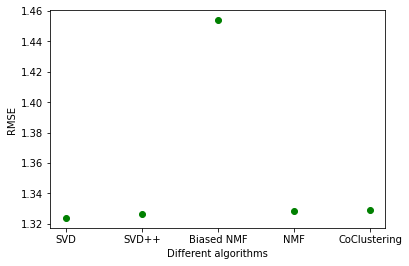

In [53]:
import matplotlib.pyplot as plt
RMSEs = [error_svd, error_svd_plus, error_nmfb, error_nmf, error_CoClustering]
algorithms = ['SVD', 'SVD++', "Biased NMF", 'NMF', 'CoClustering']
plt.plot(algorithms, RMSEs, 'go',  )
plt.xlabel("Different algorithms")
plt.ylabel("RMSE")
plt.show()


In [ ]:
#maybe consider this version
#from this: https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), NMF(), KNNBaseline()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surprise, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...


In [ ]:
# iwas trying to predict recommendation (i wanted to do something like in the box collaborative filter recommendation below)
data_test = Dataset.load_from_df(test_df, reader)
predictions = gs_svd.fit(data_surprise).test(data_test)

AttributeError: ignored

In [ ]:

#https://surprise.readthedocs.io/en/stable/FAQ.html
def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

#Baseline Model

In [ ]:
y_pred = pd.DataFrame(train_df.groupby('product_id')['review_score'].mean())

In [ ]:
val_df = test_df[['review_score','product_id']]

In [ ]:
pred_true = pd.merge(y_pred,val_df,on='product_id')
baseline_df = pred_true.rename(columns={'review_score_x':'predicted_score'})

In [ ]:
#calculating rmse
print("RMSE baseline model: ", sqrt(mean_squared_error(baseline_df["predicted_score"], 
                                                       baseline_df["review_score_y"])))

RMSE baseline model:  1.360714331149122


#Collaborative filtering recommendation

In [ ]:
raitings_df = raitings_df[:100]

In [ ]:
matrix_df = raitings_df.pivot(index = 'customer_unique_id', columns ='product_id', values = 'review_score').fillna(0)

In [ ]:
matrix_df

product_id,374,3097,3315,4518,6214,7827,8215,8748,8833,10589,10982,11968,12492,13065,14326,16040,16284,16756,17106,17238,17921,18199,19171,19859,20609,21101,21331,21404,23621,23848,23951,24398,25653,26618,27150,29448,29559,30901,31314,31571,31599,32060
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
3211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3240,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87989,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
u,s,vt = svds(matrix_df,k=10)

In [ ]:
sigma = np.diag(s)


In [ ]:
#Predicted ratings
predicted_ratings = np.dot(np.dot(u, sigma), vt) 


In [ ]:
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(predicted_ratings, columns = matrix_df.columns)
preds_df.head()

product_id,374,3097,3315,4518,6214,7827,8215,8748,8833,10589,10982,11968,12492,13065,14326,16040,16284,16756,17106,17238,17921,18199,19171,19859,20609,21101,21331,21404,23621,23848,23951,24398,25653,26618,27150,29448,29559,30901,31314,31571,31599,32060
0,-8.492478e-18,7.774402e-20,-7.998602e-17,2.952624e-16,1.775683e-17,-1.486642e-16,-2.937594e-17,8.254597e-17,4.804059e-16,-7.174860e-17,8.752865e-16,-1.973015e-16,2.470694e-16,-2.142861e-16,3.893397e-16,-1.088199e-16,8.060043e-17,-1.245792e-17,-1.748849e-17,-1.869192e-16,-3.895409e-16,3.683930e-16,2.351893e-17,-1.815890e-16,2.420612e-15,-5.834296e-17,-2.715055e-17,1.220423e-16,-5.346467e-16,-6.656269e-16,-8.434666e-16,-1.828415e-16,-6.041475e-16,1.110834e-16,2.259370e-16,-3.833265e-17,-1.676876e-19,1.759274e-16,-1.967293e-16,-4.828626e-16,5.000000e+00,-5.551115e-16
1,8.653257e-34,3.588028e-36,-3.912073e-32,4.409896e-33,9.063359e-34,2.271101e-17,-2.865374e-17,3.060665e-33,-9.937723e-18,-4.636815e-33,2.962743e-17,-5.119934e-33,3.864067e-33,-4.531850e-18,1.919387e-32,-1.177605e-33,1.088454e-33,-9.141602e-34,-7.348745e-19,-1.108652e-32,-1.311725e-32,9.207609e-33,8.516673e-34,-4.434855e-33,-6.117303e-18,-1.251370e-33,-4.705976e-34,1.246529e-32,-1.301620e-32,-4.051706e-32,-1.792331e-32,-1.103341e-32,3.663351e-17,4.403767e-33,4.073006e-33,-7.940051e-34,-2.704068e-35,8.074015e-18,-4.143777e-33,-1.009456e-32,7.367860e-17,-4.274988e-32
2,1.610400e-32,1.442572e-35,2.274098e-32,-1.661519e-33,3.306395e-33,5.278699e-17,-2.335225e-17,1.219027e-32,1.791826e-18,3.253181e-33,4.599297e-18,-8.759155e-34,-6.718343e-33,1.109844e-17,-3.170607e-33,4.721127e-33,-2.658455e-33,-2.753225e-33,-6.674797e-19,-2.792460e-32,-1.016419e-32,8.653257e-34,-1.780113e-33,-5.268868e-33,-1.408568e-17,3.918186e-33,9.792495e-34,3.900953e-32,-1.242809e-33,9.177883e-33,-2.170671e-33,-2.939497e-32,-5.012127e-17,3.570248e-33,3.108703e-34,9.227456e-34,-8.934012e-35,9.955294e-17,4.673642e-33,-1.240159e-33,-1.698496e-18,1.542909e-32
3,-5.095487e-18,4.664641e-20,-4.799161e-17,1.771575e-16,1.065410e-17,-8.919849e-17,-1.762557e-17,4.952758e-17,2.882436e-16,-4.304916e-17,5.251719e-16,-1.183809e-16,1.482416e-16,-1.285716e-16,2.336038e-16,-6.529193e-17,4.836026e-17,-7.474752e-18,-1.049309e-17,-1.121515e-16,-2.337245e-16,2.210358e-16,1.411136e-17,-1.089534e-16,1.452367e-15,-3.500577e-17,-1.629033e-17,7.322540e-17,-3.207880e-16,-3.993761e-16,-5.060800e-16,-1.097049e-16,-3.624885e-16,6.665004e-17,1.355622e-16,-2.299959e-17,-1.006126e-19,1.055565e-16,-1.180376e-16,-2.897176e-16,3.000000e+00,-3.330669e-16
4,-8.900564e-33,1.321044e-35,-4.179715e-31,1.660822e-32,-4.349805e-34,-5.149711e-17,-1.224288e-16,4.309451e-33,-2.724217e-17,-3.074462e-32,4.455524e-17,-1.679687e-32,2.043248e-32,6.235111e-17,3.953227e-32,-1.350421e-32,1.292874e-32,-8.231933e-34,-3.721110e-18,-2.241661e-32,-5.564713e-32,4.258337e-33,7.039287e-33,-1.264240e-32,8.471218e-18,-1.113378e-32,-3.919463e-33,2.611236e-32,-1.094781e-32,-1.117816e-31,-1.034740e-32,-1.496966e-32,-6.948557e-18,1.719166e-32,2.315863e-32,-3.643515e-33,-4.420461e-35,-1.012604e-16,-2.863946e-32,-3.628291e-33,2.351893e-17,-9.304033e-32


In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 1
num_recommendations =5
recommend_items(userID, matrix_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1):

                   user_ratings  user_predictions
Recommended Items                                
20609                       0.0      2.420612e-15
10982                       0.0      8.752865e-16
8833                        0.0      4.804059e-16
14326                       0.0      3.893397e-16
18199                       0.0      3.683930e-16


In [ ]:
#calculating rmse
print("RMSE collaborative model: ", sqrt(mean_squared_error(matrix_df.mean(), 
                                                       preds_df.mean())))

RMSE collaborative model:  0.05405024117826457
